<a href="https://colab.research.google.com/github/amitmakashir/Deep-learning/blob/master/Speech_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

import warnings
warnings.filterwarnings('ignore')

#### If you wish to execute this notebook, please make sure to have the training and testing audio files in the same directory as this notebook.

In [0]:
# Training data

s, sr=librosa.load('train_clean_male.wav', sr=None)
S=librosa.stft(s, n_fft=1024, hop_length=512)
sn, sr=librosa.load('train_dirty_male.wav', sr=None)
X=librosa.stft(sn, n_fft=1024, hop_length=512)

X_mod = np.abs(X.T)
S_mod = np.abs(S.T)

no_of_features = X_mod.shape[1]
no_of_training_samples = X_mod.shape[0]
print(X_mod.shape)

(2459, 513)


In [0]:
# Testing data

xt1, sr = librosa.load('test_x_01.wav', sr=None)
X_test1 = librosa.stft(xt1, n_fft=1024, hop_length=512)
xt2, sr = librosa.load('test_x_02.wav', sr=None)
X_test2 = librosa.stft(xt2, n_fft=1024, hop_length=512)

X_test1 = np.transpose(X_test1)
X_test1_mod = np.abs(X_test1)

X_test2 = np.transpose(X_test2)
X_test2_mod = np.abs(X_test2)

print(X_test1_mod.shape)

(142, 513)


In [0]:
# Network structure
hidden_units = [1024,1024]
output_nodes = S_mod.shape[1]
input_nodes = X_mod.shape[1]

# Hyperparameters
learning_rate = 0.0002
epochs = 300
minibatch_size = 65
num_iters = no_of_training_samples // minibatch_size

In [0]:
# Create placeholders for input X and labels y
x = tf.placeholder(tf.float32, [None, input_nodes])
y_true = tf.placeholder(tf.float32, [None, output_nodes])


# Constructs a neural network with the specified inputs, outputs and hidden layers
# hidden_units is a list containing hidden units at every hidden layer
# the length of hidden_units list determines the no of hidden layers
# the output_nodes determine the no of classes to be predicted
# Currently use the "He" initialization for initializing the weights
def construct_network(input_nodes, output_nodes, hidden_units):
  no_of_hidden_layers = len(hidden_units)
  W = []
  b = []
  
  initializer = tf.contrib.layers.variance_scaling_initializer()
  
  for i in range(no_of_hidden_layers + 1):
    if i == 0:   # First layer
      w = tf.Variable(initializer([input_nodes, hidden_units[i]]), dtype=tf.float32)
      bias = tf.Variable(tf.random_normal([hidden_units[i]]), dtype=tf.float32)
      
    elif i == no_of_hidden_layers:  # Last layer
      w = tf.Variable(initializer([hidden_units[i-1], output_nodes]), dtype=tf.float32)
      bias = tf.Variable(tf.random_normal([output_nodes]), dtype=tf.float32)
      
    else:  # Hidden layers
      w = tf.Variable(initializer([hidden_units[i-1], hidden_units[i]]), dtype=tf.float32)
      bias = tf.Variable(tf.random_normal([hidden_units[i]]), dtype=tf.float32)

    W.append(w)
    b.append(bias)
  
  return W,b


# Once the network is constructed, pass the input X in the network.
# Apply suitable activations in the hidden layers.
# Don't apply any activations on the last layer in this function as this function
# could be used for classification as well as regression problems
def solve(x,W,b):
  n = len(W)
  y = []
  
  for i in range(n): # First layer
    if i == 0:
      y.append(tf.nn.relu(tf.matmul(x, W[i]) + b[i]))
    
    elif i == n-1: # Last layer
      y.append(tf.matmul(y[i-1], W[i]) + b[i])
    
    else: # Hidden layers
      y.append(tf.nn.relu(tf.matmul(y[i-1], W[i]) + b[i]))
  
  return y
  

  
  
  
## Main program starts from here

## Construct the network using the given configuration 
W,b = construct_network(input_nodes, output_nodes, hidden_units)  

## "y" is the output of the network. Pass it through the relu function as we want only non-negative values
y = solve(x,W,b)
y_pred = tf.nn.relu(y[-1])
  

## Define the cost function to be optimized and the optimizer to be used  
cost = tf.losses.mean_squared_error(y_pred, y_true)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Start the session
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()


## Running the neural network
errors = []
for e in range(epochs):
  i = 0
  for iter in range(num_iters):
    
    if iter == num_iters - 1: # For the last iteration take the rest of the data
      sess.run(train_step, feed_dict={x: X_mod[i:,:], y_true: S_mod[i:,:]})
      errors.append(sess.run(cost, feed_dict={x: X_mod[i:i+minibatch_size,:], y_true: S_mod[i:i+minibatch_size,:]}))
    
    else: # For all the other iterations slice the data into batches
      sess.run(train_step, feed_dict={x: X_mod[i:i+minibatch_size,:], y_true: S_mod[i:i+minibatch_size,:]})
      errors.append(sess.run(cost, feed_dict={x: X_mod[i:i+minibatch_size,:], y_true: S_mod[i:i+minibatch_size,:]}))
      i += minibatch_size

  
## Running a feedforward on the test samples
s_test_1 = sess.run(y_pred,feed_dict={x: X_test1_mod})
s_test_2 = sess.run(y_pred,feed_dict={x: X_test2_mod})

# for calculating SNR
y_train = sess.run(y_pred,feed_dict={x: X_mod})

sess.close()

In [0]:
# Convert the output of test sample 1 to wav file
output_1 = (X_test1/X_test1_mod) * s_test_1
output_istft_1 = librosa.istft(output_1.T, hop_length=512, win_length=1024)
librosa.output.write_wav('test_s_01_recons.wav',output_istft_1, sr)

In [0]:
# Convert the output of test sample 2 to wav file
output_2 = (X_test2/X_test2_mod) * s_test_2
output_istft_2 = librosa.istft(output_2.T, hop_length=512, win_length=1024)
librosa.output.write_wav('test_s_02_recons.wav', output_istft_2, sr)

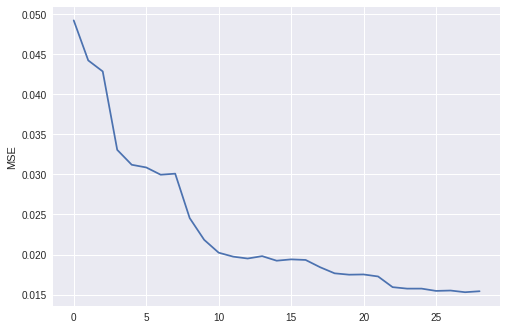

Mean squared error for the last iteration: 0.0030042797


In [0]:
def error_plot(errors,no_of_points):
  step = len(errors) // no_of_points
  
  err = [errors[i] for i in range(step,len(errors),step)]
  
  plt.plot(err)
  plt.ylabel("MSE")
  plt.show()
  
  return errors[-1]

error_plot(errors,30)
print("Mean squared error for the last iteration: " + str(errors[-1]))  

In [0]:
# y_train is the output of network
s_train_pred = (X.T/X_mod)*y_train
s_train = librosa.istft(s_train_pred.T, hop_length=512, win_length=1024)   
len_s = s_train.shape[0]


def calcSNR(s_pred_td,s_true_td):
      if s_pred_td.shape[0] != s_true_td.shape[0]:
        min_length = min(s_pred_td.shape[0],s_true_td.shape[0])
        s_pred_td = s_pred_td[:min_length]
        s_true_td = s_true_td[:min_length]
      
      signal = np.sum(np.square(s_true_td))
      noise = np.sum(np.square(s_true_td - s_pred_td))
      
      snr = 10 * np.log10(signal/noise)
      
      return snr
    
print("SNR for the training audio file: " + str(calcSNR(s_train,s)))

SNR for the training audio file: 10.579631328582764
